In [1]:
library(RBGL)
library(ggplot2)
library(dplyr, warn.conflicts = FALSE)
#library(tibble)
library("rjson")

source("lib/code_for_binary_simulations/blip_vs_bidag_plot.R")
source("lib/code_for_binary_simulations/summarySE.R")

Loading required package: graph

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: ‘gridExtra’


The following object is masked from ‘pack

In [2]:
config <- fromJSON(file = "config.json")

In [3]:
directory <- config$output_dir
dims <- config$graphs$sampled$algorithms$generateDAGMaxParents$dims[[1]]
sample_sizes <- config$data$sample_sizes[[1]]
replicates <- config$data$replicates$start:config$data$replicates$end
dag_avparents <-config$graphs$sampled$algorithms$generateDAGMaxParents$av_parents[[1]]

In [4]:
sample_sizes
dims
replicates
dag_avparents

[1] 100

[1] 80

[1] 1 2 3

[1] 2

In [5]:
rjson::fromJSON('[[[1,0], [0,1]]]', simplify = TRUE)


[[1]]
[[1]][[1]]
[1] 1 0

[[1]][[2]]
[1] 0 1

In [6]:
config

$output_dir
[1] "simresults"

$data
$data$replicates
$data$replicates$start
[1] 1

$data$replicates$end
[1] 3


$data$sample_sizes
[1] 100


$bayesian_networks
[1] "asia"

$graphs
$graphs$sampled
$graphs$sampled$algorithms
$graphs$sampled$algorithms$generateDAGMaxParents
$graphs$sampled$algorithms$generateDAGMaxParents$av_parents
[1] 2

$graphs$sampled$algorithms$generateDAGMaxParents$dims
[1] 80




$graphs$fixed
[1] "asia"


$evaluation
$evaluation$score
$evaluation$score$bdecatpar
$evaluation$score$bdecatpar$chi
[1] 1

$evaluation$score$bdecatpar$edgepf
[1] 1




$plotting
$plotting$algorithms
[1] "blip"    "gobnilp" "fges"    "pcalg"   "mmhc"   


$algorithms
$algorithms$blip
$algorithms$blip$plot_legend
[1] "blip"

$algorithms$blip$scorer.method
[1] "is"

$algorithms$blip$solver.method
[1] "winasobs"

$algorithms$blip$indeg
[1] 80

$algorithms$blip$time
[1] 60

$algorithms$blip$allocated
[1] 80

$algorithms$blip$scorefunction
[1] "bdeu"

$algorithms$blip$alpha
[1] 1

$algorithms$blip$cores
[1] 1

$algorithms$blip$verbose
[1] 0


$algorithms$gobnilp
$algorithms$gobnilp$plot_legend
[1] "gobnilp"

$algorithms$gobnilp$plot
[1] FALSE

$algorithms$gobnilp$palim
[1] 2


$algorithms$fges
$algorithms$fges$plot_legend
[1] "fges"

$algorithms$fges$faithfulnessAssumed
[1] 1


$algorithms$pcalg
$algorithms$pcalg$plot_legend
[1] "pcalg"

$algorithms$pcalg$alpha
[1] 0.01 0.05 0.10 0.20 0.35 0.45


$algorithms$mmhc
$algorithms$mmhc$plot_legend
[1] "mmhc"

$algorithms$mmhc$restrict.args
$algorithms$mmhc$restrict.args$alpha
[1] 0.01 0.05 0.10 0.20 0.35 0.45



$algorithms$itsearch_map
$algorithms$itsearch_map$plot_legend
[1] "itmap"

$algorithms$itsearch_map$optional
$algorithms$itsearch_map$optional$MAP
[1] 1

$algorithms$itsearch_map$optional$plus1it
NULL

$algorithms$itsearch_map$optional$posterior
NULL


$algorithms$itsearch_map$score_params
$algorithms$itsearch_map$score_params$bdecatpar
$algorithms$itsearch_map$score_params$bdecatpar$chi
[1] 1

$algorithms$itsearch_map$score_params$bdecatpar$edgepf
[1] 1




$algorithms$itsearch_sample
$algorithms$itsearch_sample$plot_legend
[1] "itsample"

$algorithms$itsearch_sample$optional
$algorithms$itsearch_sample$optional$MAP
[1] 0

$algorithms$itsearch_sample$optional$plus1it
[1] 6

$algorithms$itsearch_sample$optional$posterior
[1] 0.5


$algorithms$itsearch_sample$score_params
$algorithms$itsearch_sample$score_params$bdecatpar
$algorithms$itsearch_sample$score_params$bdecatpar$chi
[1] 1

$algorithms$itsearch_sample$score_params$bdecatpar$edgepf
[1] 1




$algorithms$ordermcmc_map
$algorithms$ordermcmc_map$plot_legend
[1] "omcmc_itmap"

$algorithms$ordermcmc_map$startspace
[1] "itsearch_map"

$algorithms$ordermcmc_map$optional
$algorithms$ordermcmc_map$optional$plus1
[1] TRUE


$algorithms$ordermcmc_map$score_params
$algorithms$ordermcmc_map$score_params$bdepar
$algorithms$ordermcmc_map$score_params$bdepar$chi
[1] 1

$algorithms$ordermcmc_map$score_params$bdepar$edgepf
[1] 1



$algorithms$ordermcmc_map$threshold
 [1] 0.99 0.95 0.90 0.80 0.70 0.60 0.50 0.40 0.30 0.20


$algorithms$ordermcmc_sample
$algorithms$ordermcmc_sample$plot_legend
[1] "omcmc_itsample"

$algorithms$ordermcmc_sample$startspace
[1] "itsearch_sample"

$algorithms$ordermcmc_sample$optional
$algorithms$ordermcmc_sample$optional$plus1
[1] TRUE


$algorithms$ordermcmc_sample$threshold
 [1] 0.99 0.95 0.90 0.80 0.70 0.60 0.50 0.40 0.30 0.20

$algorithms$ordermcmc_sample$score_params
$algorithms$ordermcmc_sample$score_params$bdepar
$algorithms$ordermcmc_sample$score_params$bdepar$chi
[1] 1

$algorithms$ordermcmc_sample$score_params$bdepar$edgepf
[1] 1

### Order MCMC

In [7]:
filenames <- list.files(pattern = "csv", path = file.path(directory, "res/orderMCMC"), recursive=TRUE)
ROCdf_order_mcmc_itsearch_map <- data.frame()
ROCdf_order_mcmc_itsearch_sample <- data.frame()
ROCdf_order_mcmc <- data.frame()

tmpdf <- NULL
for (filename in filenames) {
    tmpdf <- read.csv(file.path(directory, "res/orderMCMC", filename))
    ROCdf_order_mcmc <- dplyr::bind_rows(ROCdf_order_mcmc, tmpdf)
}

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and fac

In [8]:
ROCdf_order_mcmc

TPR,FPRn,logscore,SHD,avparents,replicate,algorithm,dim,sample_size,map,⋯,gamma,hardlimit,chainout,scoreout,verbose,threshold,startspace_method,startspace_params,time,legend
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<int>,<lgl>,⋯,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<fct>,<chr>,<dbl>,<chr>
0.7142857,0.1428571,-203.2311,3,2,1,orderMCMC,6,100,NA,⋯,1,15,True,False,False,0.2,itsearch,map_1/plus1it_None/posterior_None,3.00,omcmc_itmap
1.0000000,0.4285714,-259.7791,7,2,2,orderMCMC,6,100,NA,⋯,1,15,True,False,False,0.2,itsearch,map_1/plus1it_None/posterior_None,4.64,omcmc_itmap
0.7142857,0.1428571,-203.2311,3,2,1,orderMCMC,6,100,NA,⋯,1,15,True,False,False,0.2,itsearch,map_0/plus1it_6/posterior_0.5,4.66,omcmc_itsample
1.0000000,0.4285714,-259.7791,7,2,2,orderMCMC,6,100,NA,⋯,1,15,True,False,False,0.2,itsearch,map_0/plus1it_6/posterior_0.5,4.52,omcmc_itsample
0.7142857,0.1428571,-201.8395,3,2,1,orderMCMC,6,100,NA,⋯,1,15,True,False,False,0.3,itsearch,map_1/plus1it_None/posterior_None,3.00,omcmc_itmap
0.8571429,0.2857143,-278.6114,6,2,2,orderMCMC,6,100,NA,⋯,1,15,True,False,False,0.3,itsearch,map_1/plus1it_None/posterior_None,4.64,omcmc_itmap
0.7142857,0.1428571,-201.8395,3,2,1,orderMCMC,6,100,NA,⋯,1,15,True,False,False,0.3,itsearch,map_0/plus1it_6/posterior_0.5,4.66,omcmc_itsample
0.8571429,0.2857143,-278.6114,6,2,2,orderMCMC,6,100,NA,⋯,1,15,True,False,False,0.3,itsearch,map_0/plus1it_6/posterior_0.5,4.52,omcmc_itsample
0.7142857,0.0000000,-233.9774,2,2,1,orderMCMC,6,100,NA,⋯,1,15,True,False,False,0.4,itsearch,map_1/plus1it_None/posterior_None,3.00,omcmc_itmap


In [9]:
sumROC_order_mcmc = ROCdf_order_mcmc %>%
                    filter(dim %in% dims) %>%
                    filter(sample_size %in% sample_sizes) %>%
                    filter(avparents %in% dag_avparents) %>%
                    filter(replicate %in% replicates) %>%
                    # filter(is.na(itsearch_plus1it) | (itsearch_plus1it %in% config$itsearch_sample$optional$plus1it)) %>%
                    group_by(legend, threshold, sample_size, dim, avparents) %>% 
                    summarise(SHD_mean = mean(SHD),
                              TPR_mean = mean(TPR), 
                              TPR_median = median(TPR), 
                              FPRn_median = median(FPRn), 
                              TPR_q1 = quantile(TPR, probs = c(0.05)), 
                              TPR_q3 = quantile(TPR, probs = c(0.95)),
                              time_mean = mean(time),
                              logscore_mean = mean(logscore),
                              N = n()) #%>%
                    #filter(N %in% length(replicates))

In [10]:
labels <- apply(sumROC_order_mcmc, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sumROC_order_mcmc["labels"] <- labels

In [11]:
sumROC_order_mcmc

legend,threshold,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,logscore_mean,N,labels
<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
omcmc_itmap,0.20,100,80,2,100.66667,0.81706517,0.80000000,0.62500000,0.78000000,0.8660759,25.76333,-3691.953,3,"p=80, n=100, avparents=2, N=3"
omcmc_itmap,0.30,100,80,2,82.33333,0.80034576,0.77777778,0.43750000,0.76402778,0.8524613,25.76333,-3775.407,3,"p=80, n=100, avparents=2, N=3"
omcmc_itmap,0.40,100,80,2,73.00000,0.78362635,0.77777778,0.36250000,0.73027778,0.8410689,25.76333,-3871.104,3,"p=80, n=100, avparents=2, N=3"
omcmc_itmap,0.50,100,80,2,64.33333,0.76284185,0.74074074,0.30000000,0.72657407,0.8145804,25.76333,-3963.530,3,"p=80, n=100, avparents=2, N=3"
omcmc_itmap,0.60,100,80,2,64.33333,0.66684508,0.69135802,0.25000000,0.58663580,0.7298953,25.76333,-4060.890,3,"p=80, n=100, avparents=2, N=3"
omcmc_itmap,0.70,100,80,2,65.33333,0.56287766,0.58024691,0.18750000,0.45177469,0.6618222,25.76333,-4164.884,3,"p=80, n=100, avparents=2, N=3"
omcmc_itmap,0.80,100,80,2,67.66667,0.47526436,0.50617284,0.15000000,0.36561728,0.5632755,25.76333,-4281.351,3,"p=80, n=100, avparents=2, N=3"
omcmc_itmap,0.90,100,80,2,67.66667,0.35431252,0.38271605,0.11250000,0.27452160,0.4142210,25.76333,-4461.201,3,"p=80, n=100, avparents=2, N=3"
omcmc_itmap,0.95,100,80,2,69.66667,0.26279106,0.25925926,0.05000000,0.20592593,0.3221285,25.76333,-4580.701,3,"p=80, n=100, avparents=2, N=3"


### Iterative MCMC

In [12]:
filenames <- list.files(pattern = "csv", path = file.path(directory, "res/itsearch"), recursive = TRUE)
ROCdf_itsearch <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory,"res/itsearch", filename))
  # Convert "None" string to NA
    tmpdf["plus1it"] <- na_if(tmpdf["plus1it"], "None")
   tmpdf["posterior"] <- na_if(tmpdf["posterior"], "None")
    ROCdf_itsearch <- dplyr::bind_rows(ROCdf_itsearch, tmpdf)
  
}

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and fac

In [13]:
ROCdf_itsearch

TPR,FPRn,logscore,SHD,avparents,replicate,algorithm,dim,sample_size,plus1it,⋯,mergetype,addspace,scoretable,startorder,accum,score_type,bdecatpar_chi,bdecatpar_edgepf,time,legend
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,⋯,<fct>,<lgl>,<lgl>,<lgl>,<fct>,<fct>,<int>,<int>,<dbl>,<chr>
0.7142857,0.0000000,-174.2625,2,2,1,itsearch,6,100,6,⋯,skeleton,NA,NA,NA,False,bde,1,1,17.06,itsample
0.5714286,0.2857143,-263.8857,6,2,2,itsearch,6,100,6,⋯,skeleton,NA,NA,NA,False,bde,1,1,17.17,itsample
0.7142857,0.0000000,-174.2625,2,2,1,itsearch,6,100,NA,⋯,skeleton,NA,NA,NA,False,bde,1,1,6.03,itmap
0.8571429,0.4285714,-269.9932,7,2,2,itsearch,6,100,NA,⋯,skeleton,NA,NA,NA,False,bde,1,1,6.14,itmap
0.6250000,0.2250000,-3891.9464,76,2,1,itsearch,80,100,6,⋯,skeleton,NA,NA,NA,False,bde,1,1,75.39,itsample
0.5925926,0.1851852,-3855.9240,67,2,2,itsearch,80,100,6,⋯,skeleton,NA,NA,NA,False,bde,1,1,72.98,itsample
0.6708861,0.1645570,-3857.5961,58,2,3,itsearch,80,100,6,⋯,skeleton,NA,NA,NA,False,bde,1,1,87.76,itsample
0.8000000,0.6250000,-3529.4999,92,2,1,itsearch,80,100,NA,⋯,skeleton,NA,NA,NA,False,bde,1,1,52.64,itmap
0.7777778,0.5432099,-3660.8587,98,2,2,itsearch,80,100,NA,⋯,skeleton,NA,NA,NA,False,bde,1,1,57.91,itmap


In [18]:
names(ROCdf_itsearch)

[1] "TPR"              "FPRn"             "logscore"         "SHD"             
 [5] "avparents"        "replicate"        "algorithm"        "dim"             
 [9] "sample_size"      "plus1it"          "moveprobs"        "MAP"             
[13] "posterior"        "iterations"       "stepsave"         "softlimit"       
[17] "hardlimit"        "alpha"            "gamma"            "startspace"      
[21] "blacklist"        "verbose"          "chainout"         "scoreout"        
[25] "cpdag"            "mergetype"        "addspace"         "scoretable"      
[29] "startorder"       "accum"            "score_type"       "bdecatpar_chi"   
[33] "bdecatpar_edgepf" "time"             "legend"

In [14]:
#ROCdf_itsearch$algorithm <- apply(ROCdf_itsearch["MAP"], 1, 
# function(a){
#    if(a==TRUE){ 
#        return("itsearch_map")
#     }else {
#        return("itsearch_sample")
#      }
#  })                                          

In [19]:
sum_roc_itsearch <- ROCdf_itsearch %>% 
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% dag_avparents) %>%
                filter(is.na(plus1it) | (plus1it %in% config$algorithms$itsearch_sample$optional$plus1it)) %>%
                 group_by(legend, sample_size, dim, avparents) %>% 
                 summarise( SHD_mean = mean(SHD),
                           TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                          logscore_mean =  mean(logscore),
                           time_mean = mean(time),
                         #  it_mean = mean(it),
                          N = n()) #%>%
                    #filter(N %in% length(replicates))0

labels <- apply(sum_roc_itsearch, 1, function(row) {
    paste("p=",row["dim"],", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sum_roc_itsearch["labels"] <- labels 

In [20]:
labels

[1] "p=80, n=100, avparents=2, N=3" "p=80, n=100, avparents=2, N=3"

In [21]:
sum_roc_itsearch

legend,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,logscore_mean,time_mean,N,labels
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
itmap,100,80,2,100,0.8044069,0.800,0.6250000,0.7800000,0.8318987,-3608.414,77.64333,3,"p=80, n=100, avparents=2, N=3"
itsample,100,80,2,67,0.6294929,0.625,0.1851852,0.5958333,0.6662975,-3868.489,78.71000,3,"p=80, n=100, avparents=2, N=3"


### PC algorithm

In [22]:
filenames <- list.files(pattern = "csv", path = file.path(directory, "res/pcalg"), recursive = TRUE)
roc_pcalg <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, "res/pcalg", filename))
  roc_pcalg <- dplyr::bind_rows(roc_pcalg, tmpdf)
}

In [23]:
roc_pcalg

TPR,FPRn,logscore,SHD,avparents,replicate,algorithm,alpha,dim,sample_size,⋯,fixedEdges,NAdelete,m.max,conservative,maj.rule,solve.confl,numCores,verbose,time,legend
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<dbl>,<int>,<int>,⋯,<lgl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<fct>
0.7142857,0.00000000,-187.8285,4,2,1,pcalg,0.01,6,100,⋯,NA,True,Inf,False,False,False,1,False,3.21,pcalg
0.5714286,0.00000000,-282.8309,5,2,2,pcalg,0.01,6,100,⋯,NA,True,Inf,False,False,False,1,False,3.02,pcalg
0.7142857,0.00000000,-174.2625,2,2,1,pcalg,0.05,6,100,⋯,NA,True,Inf,False,False,False,1,False,3.12,pcalg
0.5714286,0.14285714,-281.9363,7,2,2,pcalg,0.05,6,100,⋯,NA,True,Inf,False,False,False,1,False,2.09,pcalg
0.5714286,0.00000000,-183.8087,3,2,1,pcalg,0.10,6,100,⋯,NA,True,Inf,False,False,False,1,False,3.03,pcalg
0.5714286,0.14285714,-281.9363,7,2,2,pcalg,0.10,6,100,⋯,NA,True,Inf,False,False,False,1,False,2.74,pcalg
0.5714286,0.00000000,-183.8087,3,2,1,pcalg,0.20,6,100,⋯,NA,True,Inf,False,False,False,1,False,3.14,pcalg
0.5714286,0.14285714,-260.7061,5,2,2,pcalg,0.20,6,100,⋯,NA,True,Inf,False,False,False,1,False,3.08,pcalg
0.7142857,0.00000000,-174.2625,2,2,1,pcalg,0.35,6,100,⋯,NA,True,Inf,False,False,False,1,False,2.15,pcalg


In [24]:
sum_roc_pcalg <- roc_pcalg %>% 
                 filter(dim %in% dims) %>%
                 filter(sample_size %in% sample_sizes) %>%         
                 filter(avparents %in% dag_avparents) %>%
                filter(replicate %in% replicates) %>%
                 group_by(legend, alpha, sample_size, dim, avparents) %>% 
                 summarise(
                          SHD_mean = mean(SHD),
                          TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                          time_mean = mean(time),
                          N = n())# %>% ungroup() %>%
#                 filter(N %in% replicates)
labels <- apply(sum_roc_pcalg, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sum_roc_pcalg["labels"] <- labels 

In [25]:
sum_roc_pcalg

legend,alpha,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,N,labels
<fct>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
pcalg,0.01,100,80,2,57.00000,0.5209395,0.5250000,0.02531646,0.5080556,0.5309810,6.566667,3,"p=80, n=100, avparents=2, N=3"
pcalg,0.05,100,80,2,56.33333,0.6042819,0.6000000,0.06329114,0.5933333,0.6182278,8.260000,3,"p=80, n=100, avparents=2, N=3"
pcalg,0.10,100,80,2,61.33333,0.6250111,0.6075949,0.10000000,0.6052039,0.6570095,10.830000,3,"p=80, n=100, avparents=2, N=3"
pcalg,0.20,100,80,2,68.33333,0.6336068,0.6500000,0.21518987,0.5983333,0.6574051,17.286667,3,"p=80, n=100, avparents=2, N=3"
pcalg,0.35,100,80,2,72.33333,0.6501192,0.6582278,0.27500000,0.6324895,0.6620728,38.043333,3,"p=80, n=100, avparents=2, N=3"
pcalg,0.45,100,80,2,74.33333,0.6625163,0.6582278,0.32500000,0.6547117,0.6733228,62.220000,3,"p=80, n=100, avparents=2, N=3"


### Max-Min hill climbing

In [26]:
filenames <- list.files(pattern = "csv", path = file.path(directory, "res/mmhc"), recursive = TRUE)

roc_mmhc <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, "res/mmhc", filename))
  roc_mmhc <- dplyr::bind_rows(roc_mmhc, tmpdf)
}

In [27]:
roc_mmhc

TPR,FPRn,logscore,SHD,avparents,replicate,algorithm,dim,sample_size,score,bdecatpar_chi,bdecatpar_edgepf,alpha,whitelist,debug,maximize.args,time,legend
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<lgl>,<fct>,<lgl>,<dbl>,<fct>
0.7142857,0.00000000,-259.5675,4,2,1,mmhc,6,100,bde,1,1,0.01,NA,False,NA,3.00,mmhc
0.5714286,0.00000000,-312.6452,5,2,2,mmhc,6,100,bde,1,1,0.01,NA,False,NA,2.07,mmhc
0.7142857,0.00000000,-259.5675,4,2,1,mmhc,6,100,bde,1,1,0.05,NA,False,NA,3.10,mmhc
0.5714286,0.14285714,-308.3732,5,2,2,mmhc,6,100,bde,1,1,0.05,NA,False,NA,3.07,mmhc
0.7142857,0.00000000,-259.5675,4,2,1,mmhc,6,100,bde,1,1,0.10,NA,False,NA,2.94,mmhc
0.5714286,0.14285714,-308.3732,5,2,2,mmhc,6,100,bde,1,1,0.10,NA,False,NA,3.06,mmhc
0.7142857,0.00000000,-259.5675,4,2,1,mmhc,6,100,bde,1,1,0.20,NA,False,NA,2.96,mmhc
0.5714286,0.14285714,-308.3732,5,2,2,mmhc,6,100,bde,1,1,0.20,NA,False,NA,3.15,mmhc
0.7142857,0.00000000,-259.5675,4,2,1,mmhc,6,100,bde,1,1,0.35,NA,False,NA,3.26,mmhc


In [28]:
sum_roc_mmhc <- roc_mmhc %>% 
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                    filter(avparents %in% dag_avparents) %>% 
                filter(replicate %in% replicates) %>%
                 group_by(legend, alpha, sample_size, dim, avparents) %>% 
                 summarise( SHD_mean = mean(SHD),
                           TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                           time_mean = mean(time),
                          N = n()) #%>% ungroup() %>%
                    #filter(N %in% replicates)

labels <- apply(sum_roc_mmhc, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sum_roc_mmhc["labels"] <- labels 

In [29]:
sum_roc_mmhc

legend,alpha,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,N,labels
<fct>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
mmhc,0.01,100,80,2,51.33333,0.5501628,0.5432099,0.02531646,0.5268210,0.5783716,2.810000,3,"p=80, n=100, avparents=2, N=3"
mmhc,0.05,100,80,2,55.00000,0.5917806,0.5875000,0.07407407,0.5809722,0.6055854,2.773333,3,"p=80, n=100, avparents=2, N=3"
mmhc,0.10,100,80,2,54.33333,0.6209486,0.6202532,0.10000000,0.5953586,0.6470253,2.743333,3,"p=80, n=100, avparents=2, N=3"
mmhc,0.20,100,80,2,55.66667,0.6377735,0.6582278,0.15000000,0.5991561,0.6620728,2.846667,3,"p=80, n=100, avparents=2, N=3"
mmhc,0.35,100,80,2,57.66667,0.6544942,0.6750000,0.16250000,0.6119444,0.6826899,2.796667,3,"p=80, n=100, avparents=2, N=3"
mmhc,0.45,100,80,2,57.33333,0.6670997,0.6875000,0.16455696,0.6131944,0.7067247,2.906667,3,"p=80, n=100, avparents=2, N=3"


## FGES

In [30]:
filenames <- list.files(pattern = "csv", path = file.path(directory, "res/fges"), recursive = TRUE)

roc_fges <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, "res/fges", filename))
  roc_fges <- dplyr::bind_rows(roc_fges, tmpdf)
}

In [31]:
roc_fges

TPR,FPRn,logscore,SHD,avparents,replicate,algorithm,dim,sample_size,score,faithfulnessAssumed,time,legend
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<int>,<fct>,<int>,<dbl>,<fct>
0.8571429,0.00000000,-178.8738,1,2,1,fges,6,100,bde,1,2.83,fges
0.7142857,0.28571429,-260.3700,8,2,2,fges,6,100,bde,1,2.83,fges
0.6375000,0.03750000,-3591.7183,43,2,1,fges,80,100,bde,1,3.51,fges
0.6172840,0.00000000,-3681.8268,48,2,2,fges,80,100,bde,1,3.26,fges
0.6708861,0.08860759,-3584.8162,49,2,3,fges,80,100,bde,1,4.00,fges


In [32]:
sum_roc_fges <- roc_fges %>% 
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                    filter(avparents %in% dag_avparents) %>% 
                filter(replicate %in% replicates) %>%
                 group_by(legend, sample_size, dim, avparents) %>% 
                 summarise( SHD_mean = mean(SHD),
                           TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                           time_mean = mean(time),
                          N = n()) #%>% ungroup() %>%
                    #filter(N %in% replicates)

labels <- apply(sum_roc_fges, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sum_roc_fges["labels"] <- labels 

In [33]:
sum_roc_fges

legend,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,N,labels
<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
fges,100,80,2,46.66667,0.64189,0.6375,0.0375,0.6193056,0.6675475,3.59,3,"p=80, n=100, avparents=2, N=3"


### Blip

In [34]:
filenames <- list.files(pattern = "csv", path = file.path(directory, "res/blip"), recursive = TRUE)

ROCdf_blip <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, "res/blip", filename))
  ROCdf_blip <- dplyr::bind_rows(ROCdf_blip, tmpdf)
}

In [35]:
ROCdf_blip

TPR,FPRn,logscore,SHD,avparents,replicate,algorithm,dim,sample_size,score,⋯,scorer.method,solver.method,indeg,cores,allocated,scorefunction,alpha,verbose,time,legend
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<int>,<fct>,⋯,<fct>,<fct>,<int>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<fct>
0.7142857,0.0000000,-251.8748,2,2,1,blip,6,100,bde,⋯,is,winasobs,80,1,80,bdeu,1,0,5.70,blip
0.7142857,0.2857143,-297.4570,8,2,2,blip,6,100,bde,⋯,is,winasobs,80,1,80,bdeu,1,0,6.80,blip
0.8500000,1.5125000,-3796.4196,175,2,1,blip,80,100,bde,⋯,is,winasobs,80,1,80,bdeu,1,0,13.41,blip
0.7654321,1.2469136,-4053.5575,154,2,14,blip,80,100,bde,⋯,is,winasobs,80,1,80,bdeu,1,0,13.72,blip
0.7974684,1.4810127,-3783.7009,174,2,16,blip,80,100,bde,⋯,is,winasobs,80,1,80,bdeu,1,0,13.29,blip
0.8101266,1.3291139,-4022.8513,158,2,17,blip,80,100,bde,⋯,is,winasobs,80,1,80,bdeu,1,0,13.70,blip
0.8625000,1.4625000,-3800.5695,164,2,19,blip,80,100,bde,⋯,is,winasobs,80,1,80,bdeu,1,0,13.91,blip
0.7777778,1.4320988,-3909.3072,168,2,2,blip,80,100,bde,⋯,is,winasobs,80,1,80,bdeu,1,0,13.79,blip
0.8024691,1.4320988,-3521.0114,171,2,22,blip,80,100,bde,⋯,is,winasobs,80,1,80,bdeu,1,0,13.28,blip


# Fix so that scores are calculated on the same data set

In [36]:
blip_scores <- ROCdf_blip %>% 
                select(c("legend","replicate", "avparents", "sample_size", "dim", "logscore", "max_time")) %>%
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% dag_avparents) %>% 
                filter(replicate %in% replicates)
rename(blip_scores, logscore_blip=logscore)

legend,replicate,avparents,sample_size,dim,logscore_blip,max_time
<fct>,<int>,<int>,<int>,<int>,<dbl>,<int>
blip,1,2,100,80,-3796.420,10
blip,2,2,100,80,-3909.307,10
blip,3,2,100,80,-3877.792,10


In [37]:
blip_scores <- ROCdf_blip %>% 
                select(c("legend","replicate", "avparents", "sample_size", "dim", "logscore", "max_time")) %>%
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% dag_avparents) %>% 
                filter(replicate %in% replicates) 
blip_scores <- rename(blip_scores, logscore_blip=logscore)
blip_scores <- rename(blip_scores, legend_blip=legend)


itsearch_scores <- ROCdf_itsearch %>% 
                select(c("legend","replicate", "avparents", "sample_size", "dim", "logscore")) %>%
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% dag_avparents) %>% 
                filter(replicate %in% replicates) 
itsearch_scores <- rename(itsearch_scores, logscore_itsearch=logscore)
itsearch_scores <- rename(itsearch_scores, legend_itsearch=legend)

order_mcmc_scores <- ROCdf_order_mcmc %>% 
                select(c("legend","replicate", "avparents", "sample_size", "dim", "logscore")) %>%
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% dag_avparents) %>% 
                filter(replicate %in% replicates) 
order_mcmc_scores <- rename(order_mcmc_scores, logscore_order_mcmc=logscore)
order_mcmc_scores <- rename(order_mcmc_scores, legend_order_mcmc=legend)

#blip_scores
#itsearch_scores
#order_mcmc_scores

cols <- c("replicate", "avparents", "sample_size", "dim")

scores <- left_join(blip_scores, itsearch_scores, by=cols)
scores$blip_minus_itsearch <- scores$logscore_blip - scores$logscore_itsearch
difflogscore_itsearch <- scores

#print(difflogscore_itsearch)
#scores <- blip_scores %>% left_join(itsearch_scores,by=c("replicate", "avparents", "sample_size", "dim"), suffix = c(".blip",".itsearch")) %>%
#        left_join(order_mcmc_scores,by=c("replicate", "avparents", "sample_size", "dim"), suffix = c(".blip",".itsearch"), name="test")
difflogscore_itsearch <- difflogscore_itsearch %>% 
                         group_by(legend_itsearch, sample_size, dim, avparents) %>% 
                         summarise(logscore_mean=mean(blip_minus_itsearch),        
                        N=n())

labels <- apply(difflogscore_itsearch, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})


# TODO: Compare to one of the blip max_times
difflogscore_itsearch["labels"] <- labels 

difflogscore_itsearch

legend_itsearch,sample_size,dim,avparents,logscore_mean,N,labels
<chr>,<int>,<int>,<int>,<dbl>,<int>,<chr>
itmap,100,80,2,-252.759256,3,"p=80, n=100, avparents=2, N=3"
itsample,100,80,2,7.315949,3,"p=80, n=100, avparents=2, N=3"


In [38]:
#ggplot() + 
#geom_point(data = sumROC_order_mcmc,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_text(data = sumROC_order_mcmc,
#          aes(x = algorithm, 
#               y = logscore_mean,               
#                col = algorithm, label=threshold),
#            check_overlap = TRUE,
#           nudge_x=0.2,
#          nudge_y=0.9) +

#geom_point(data = sum_roc_pcalg,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_mmhc,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +

#geom_point(data = sum_roc_blip,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_itsearch,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#theme(axis.text.x = element_text(angle = 10),
#      legend.position = "none") +
#facet_wrap(. ~ labels, scales="free_y") +
#ylab("Mean log-score") +
#xlab("Algorithm") +
#ggsave(file=file.path("logscore.eps"))


In [39]:
sum_roc_blip <- ROCdf_blip %>% 
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% dag_avparents) %>%      
                filter(replicate %in% replicates) %>%
                filter(indeg %in% config$algorithms$blip$indeg) %>%
                 group_by(legend, sample_size, dim,max_time, avparents) %>% 
                 summarise( SHD_mean = mean(SHD),
                           TPR_mean = mean(TPR),
                          time_mean=mean(time),
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)),
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                           logscore_mean = mean(logscore),
                          N = n())#%>%
                    #filter(N %in% replicates)
labels <- apply(sum_roc_blip, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sum_roc_blip["labels"] <- labels 

In [40]:
sum_roc_blip

legend,sample_size,dim,max_time,avparents,SHD_mean,TPR_mean,time_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,logscore_mean,N,labels
<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
blip,100,80,10,2,166.6667,0.8295124,13.68,0.85,1.432099,0.785,0.8596835,-3861.173,3,"p=80, n=100, avparents=2, N=3"


### GoBNiLP

In [41]:
filenames <- list.files(pattern = "csv", path = file.path(directory, "res/gobnilp"), recursive = TRUE)

ROCdf_gobnilp <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, "res/gobnilp", filename))
  ROCdf_gobnilp <- dplyr::bind_rows(ROCdf_gobnilp, tmpdf)
}

In [42]:
ROCdf_gobnilp

TPR,FPRn,logscore,SHD,avparents,replicate,algorithm,dim,sample_size,score,bdecatpar_chi,bdecatpar_edgepf,palim,time,legend
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<int>,<fct>,<int>,<int>,<int>,<dbl>,<fct>
0.7142857,0.0000000,-278.8478,2,2,1,gobnilp,6,100,bde,1,1,2,0.071260,gobnilp
0.7142857,0.2857143,-330.7735,8,2,2,gobnilp,6,100,bde,1,1,2,0.070041,gobnilp
0.7750000,0.9625000,-4262.3110,130,2,1,gobnilp,80,100,bde,1,1,2,1.251101,gobnilp
0.8024691,0.8765432,-4400.5764,123,2,2,gobnilp,80,100,bde,1,1,2,3.751649,gobnilp
0.8481013,0.8987342,-4342.6439,119,2,3,gobnilp,80,100,bde,1,1,2,2.362870,gobnilp


In [43]:
sum_roc_gobnilp <- ROCdf_gobnilp %>% 
                filter(dim %in% dims) %>%
                    filter(sample_size %in% sample_sizes) %>%
                    filter(avparents %in% avparents) %>%          
                filter(replicate %in% replicates) %>%
                   group_by(legend, sample_size, dim, avparents, palim) %>% 
                 summarise( SHD_mean = mean(SHD),
                     TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)),
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                           time_mean = mean(time),
                          N = n())#%>%
                    #filter(N %in% length(replicates))
labels <- apply(sum_roc_gobnilp, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sum_roc_gobnilp["labels"] <- labels 

In [44]:
sum_roc_gobnilp

legend,sample_size,dim,avparents,palim,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,N,labels
<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
gobnilp,100,80,2,2,124,0.8085235,0.8024691,0.8987342,0.7777469,0.8435381,2.455207,3,"p=80, n=100, avparents=2, N=3"


In [45]:
sumROC_order_mcmc

legend,threshold,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,logscore_mean,N,labels
<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
omcmc_itmap,0.20,100,80,2,100.66667,0.81706517,0.80000000,0.62500000,0.78000000,0.8660759,25.76333,-3691.953,3,"p=80, n=100, avparents=2, N=3"
omcmc_itmap,0.30,100,80,2,82.33333,0.80034576,0.77777778,0.43750000,0.76402778,0.8524613,25.76333,-3775.407,3,"p=80, n=100, avparents=2, N=3"
omcmc_itmap,0.40,100,80,2,73.00000,0.78362635,0.77777778,0.36250000,0.73027778,0.8410689,25.76333,-3871.104,3,"p=80, n=100, avparents=2, N=3"
omcmc_itmap,0.50,100,80,2,64.33333,0.76284185,0.74074074,0.30000000,0.72657407,0.8145804,25.76333,-3963.530,3,"p=80, n=100, avparents=2, N=3"
omcmc_itmap,0.60,100,80,2,64.33333,0.66684508,0.69135802,0.25000000,0.58663580,0.7298953,25.76333,-4060.890,3,"p=80, n=100, avparents=2, N=3"
omcmc_itmap,0.70,100,80,2,65.33333,0.56287766,0.58024691,0.18750000,0.45177469,0.6618222,25.76333,-4164.884,3,"p=80, n=100, avparents=2, N=3"
omcmc_itmap,0.80,100,80,2,67.66667,0.47526436,0.50617284,0.15000000,0.36561728,0.5632755,25.76333,-4281.351,3,"p=80, n=100, avparents=2, N=3"
omcmc_itmap,0.90,100,80,2,67.66667,0.35431252,0.38271605,0.11250000,0.27452160,0.4142210,25.76333,-4461.201,3,"p=80, n=100, avparents=2, N=3"
omcmc_itmap,0.95,100,80,2,69.66667,0.26279106,0.25925926,0.05000000,0.20592593,0.3221285,25.76333,-4580.701,3,"p=80, n=100, avparents=2, N=3"


## Plot ROC curves

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 9. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 20 rows containing missing values (geom_point).”
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

Saving 6.67 x 6.67 in image

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 9. Consider
specifying shapes manually if you must have them.”
Warnin

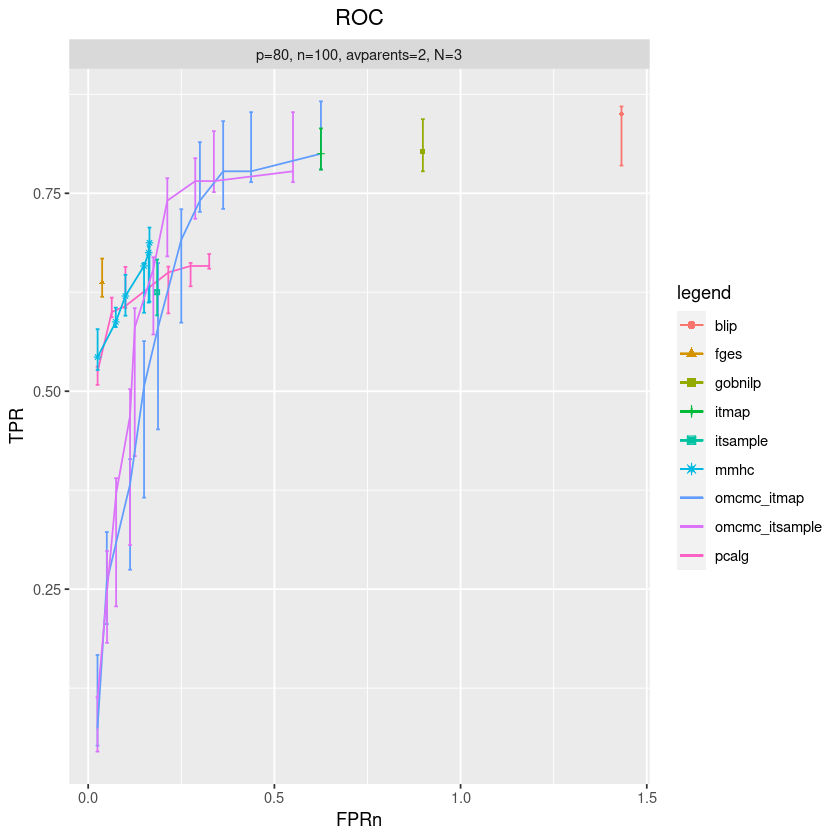

In [46]:
ggplot() +
# PC algorithm
geom_errorbar(data = sum_roc_pcalg,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = legend), 
              width = 0.01) +
geom_path(data = sum_roc_pcalg,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = legend)) +
geom_point(data = sum_roc_pcalg,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = legend, 
               shape = legend), 
               size = 1) + 
 #geom_text(data = sum_roc_pcalg,
 #           aes(x = FPRn_median, 
 #               y = TPR_q3,               
 #               label=alpha, col=legend),
 #         check_overlap = TRUE,
 #          nudge_x=-0.02,
 #         nudge_y=0.02
 #         ) +

# Max-min hill- climbing 
geom_errorbar(data = sum_roc_mmhc,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = legend), 
              width = 0.01) +
geom_path(data = sum_roc_mmhc,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = legend)) +
geom_point(data = sum_roc_mmhc,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = legend, 
               shape = legend), 
               size = 1) + 
# geom_text(data = sum_roc_mmhc,
#            aes(x = FPRn_median, 
#                y = TPR_q3,               
#                label=alpha, col=legend),
#          check_overlap = TRUE,
#           nudge_x=-0.02,
#          nudge_y=0.02
#          ) +

# Order mcmc
geom_errorbar(data = sumROC_order_mcmc,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = legend), 
              width = 0.01) +
geom_path(data = sumROC_order_mcmc,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = legend)) +
geom_point(data = sumROC_order_mcmc,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = legend, 
               shape = legend), 
               size = 2) +
# geom_text(data = sumROC_order_mcmc,
#            aes(x = FPRn_median, 
#                y = TPR_q3,               
#                col = legend, label=threshold),
#            check_overlap = TRUE,
#           nudge_x=-0.02,
#          nudge_y=0.02) +

# Iterative search
geom_errorbar(data = sum_roc_itsearch,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = legend), 
              width = 0.01) +
geom_path(data = sum_roc_itsearch,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = legend)) +
geom_point(data = sum_roc_itsearch,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = legend, 
               shape = legend), 
               size = 1) +
# Blip
geom_errorbar(data = sum_roc_blip,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = legend), 
              width = 0.01) +
geom_path(data = sum_roc_blip,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = legend)) +
geom_point(data = sum_roc_blip,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = legend, 
               shape = legend), 
               size = 1) +
# Gobnilp
 geom_errorbar(data = sum_roc_gobnilp,
               aes(x = FPRn_median,
                   ymin = TPR_q1, 
                   ymax = TPR_q3, 
                   col = legend), 
               width = 0.01) +
 geom_path(data = sum_roc_gobnilp,
           aes(x = FPRn_median, 
               y = TPR_median,
               col = legend)) +
 geom_point(data = sum_roc_gobnilp,
            aes(x = FPRn_median, 
                y = TPR_median,               
                col = legend, 
                shape = legend), 
                size = 1) +
# FGES
 geom_errorbar(data = sum_roc_fges,
               aes(x = FPRn_median,
                   ymin = TPR_q1, 
                   ymax = TPR_q3, 
                   col = legend), 
               width = 0.01) +
 geom_path(data = sum_roc_fges,
           aes(x = FPRn_median, 
               y = TPR_median,
               col = legend)) +
 geom_point(data = sum_roc_fges,
            aes(x = FPRn_median, 
                y = TPR_median,               
                col = legend, 
                shape = legend), 
                size = 1) +
# Subplot
# 

# put full label in the dataframe and save it as label.
# then write  facet_wrap(. ~ label)

#facet_wrap(. ~ dim + avparents + sample_size + N, scales="free_x", nrow = 2) +
facet_wrap(. ~ labels, scales="free_x", nrow = 2) +

# Titles etc
xlab("FPRn") +
ylab("TPR") +
ggtitle("ROC") +
theme(plot.title = element_text(hjust = 0.5))
ggsave(file=file.path("ROC.eps"))

In [933]:
#ggplot() + 
#geom_point(data = sumROC_order_mcmc,
#          aes(x = algorithm,
#              y = SHD_mean,
#              col = algorithm)) +
#geom_text(data = sumROC_order_mcmc,
#          aes(x = algorithm, 
#               y = SHD_mean,               
#                col = algorithm, label=threshold),
#            check_overlap = TRUE,
#           nudge_x=0.2,
#          nudge_y=0.9) +

#geom_point(data = sum_roc_pcalg,
#          aes(x = algorithm,
#              y = SHD_mean,
#              col = algorithm)) +
#geom_text(data = sum_roc_pcalg,
#          aes(x = algorithm, 
#               y = SHD_mean,               
#                col = algorithm, label=alpha),
#            check_overlap = TRUE,
#           nudge_x=0.2,
#          nudge_y=0.9) +

#geom_point(data = sum_roc_mmhc,
#          aes(x = algorithm,
#              y = SHD_mean,
#              col = algorithm)) +
#geom_text(data = sum_roc_mmhc,
#          aes(x = algorithm, 
#               y = SHD_mean,               
#                col = algorithm, label=alpha),
#            check_overlap = TRUE,
#           nudge_x=0.2,
#          nudge_y=0.9) +

#geom_point(data = sum_roc_blip,
#          aes(x = algorithm,
#              y = SHD_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_itsearch,
#          aes(x = algorithm,
#              y = SHD_mean,
#              col = algorithm)) +
#theme(axis.text.x = element_text(angle = 15), legend.position = "none") +
#facet_wrap(. ~ labels, scales="free_x") +
#ylab("Mean SHD") +
#xlab("Algorithm") 
#ggsave(file=file.path("SHD.eps"))

## Logscores

In [934]:
#ggplot() + 
#geom_point(data = sumROC_order_mcmc,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_text(data = sumROC_order_mcmc,
#          aes(x = algorithm, 
#               y = logscore_mean,               
#                col = algorithm, label=threshold),
#            check_overlap = TRUE,
#           nudge_x=0.2,
#          nudge_y=0.9) +

#geom_point(data = sum_roc_pcalg,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_mmhc,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_blip,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_itsearch,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#theme(axis.text.x = element_text(angle = 10),
#      legend.position = "none") +
#facet_wrap(. ~ labels, scales="free_y") +
#ylab("Mean log-score") +
#xlab("Algorithm") +
#ggsave(file=file.path("logscore.eps"))


## Times

In [935]:
#ggplot() + 
#geom_point(data = sumROC_order_mcmc,
#          aes(x = algorithm,
#              y = time_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_pcalg,
#          aes(x = algorithm,
#              y = time_mean,
#              col = algorithm)) +
#geom_text(data = sum_roc_pcalg,
#          aes(x = algorithm, 
#               y = time_mean,               
#                col = algorithm, label=alpha),
#            check_overlap = TRUE,
#           nudge_x=0.2,
#          nudge_y=0.9) +

#geom_point(data = sum_roc_mmhc,
#          aes(x = algorithm,
#              y = time_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_blip,
#          aes(x = algorithm,
#              y = time_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_itsearch,
#          aes(x = algorithm,
#              y = time_mean,
#             col = algorithm)) +
#theme(axis.text.x = element_text(angle = 10), legend.position = "none") +
#facet_wrap(dim ~ sample_size + N + avparents, scales="free_x") +
#ylab("Mean run time (s)") +
#xlab("Algorithm") 
#ggsave(file=file.path("runtimes.eps"))